# Hotele na wakacje

## Wstępna ocena przydatności danych

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.naive_bayes import CategoricalNB
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.ensemble import RandomForestClassifier

sns.set()

In [2]:
df = pd.read_csv('hotels2.csv', index_col='id')

In [3]:
df.describe()

,latitude,longitude,ranking,ranking_out_of,rating,num_reviews,photo_count
count,1165.000000,1165.000000,1165.00000,1165.000000,1165.000000,1165.000000,1165.000000
mean,31.607489,35.995338,147.04206,597.191416,4.337339,1929.244635,1560.814592
std,6.851927,19.677281,155.82979,372.791391,0.508456,2405.844558,2328.728259
min,24.816820,2.070631,1.00000,1.000000,2.500000,1.000000,0.000000
25%,25.220015,27.138655,24.00000,218.000000,4.000000,219.000000,168.000000
50%,27.907465,34.327927,81.00000,553.000000,4.500000,1073.000000,596.000000
75%,38.424140,55.266380,242.00000,982.000000,4.500000,2607.000000,1857.000000
max,41.435448,55.662610,697.00000,1202.000000,5.000000,15221.000000,13798.000000


In [4]:
df.select_dtypes(exclude=["number"]).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1165 entries, 1006161 to 9865057
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         1165 non-null   object
 1   region       1165 non-null   object
 2   country      1165 non-null   object
 3   amenities    1125 non-null   object
 4   brand        487 non-null    object
 5   awards       598 non-null    object
 6   price_level  1165 non-null   object
dtypes: object(7)
memory usage: 72.8+ KB


## Przygotowanie danych

In [7]:
df['price_level_num'] = df.price_level.apply(len)

In [31]:
df['ranking_relation'] = round(df.ranking / df.ranking_out_of, 2)
# dropped Y's low correlation ranking and name
X = df.drop(['price_level', 'price_level_num', 'ranking', 'name', 'amenities', 'awards'], axis= 'columns')
X = X.join(df.amenities.str.get_dummies(',').add_prefix('amenities_'))
X = X.join(df.awards.str.get_dummies(',').add_prefix('awards_'))
X = pd.get_dummies(X)
X.columns

Index(['latitude', 'longitude', 'ranking_out_of', 'rating', 'num_reviews',
       'photo_count', 'ranking_relation', 'amenities_ DVDs',
       'amenities_ Music for Children', 'amenities_24-Hour Check-in',
       ...
       'brand_Vida Hotels and Resorts', 'brand_Vincci', 'brand_Voco Hotels',
       'brand_W Hotels', 'brand_Waldorf Astoria Hotels & Resorts',
       'brand_Westin', 'brand_Wyndham', 'brand_Wyndham Grand', 'brand_ibis',
       'brand_ibis Styles'],
      dtype='object', length=518)

In [34]:
X_scaled = minmax_scale(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df.price_level_num, test_size=0.2, random_state=1)
X_train_split, X_validation, y_train_split, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
X_train.shape, X_train_split.shape, X_validation.shape, X_test.shape

((932, 518), (745, 518), (187, 518), (233, 518))

## Modelowanie

Algorytm naiwny zawsze wybierając 2 będzie miał 47% dokładności

In [36]:
knn = KNeighborsClassifier()
param_grid = {"n_neighbors": np.arange(1, 20)}
knn_gscv = GridSearchCV(knn, param_grid, cv=10)
knn_gscv.fit(X_train, y_train)
knn_gscv.best_params_, knn_gscv.best_score_

({'n_neighbors': 6}, 0.6555364905056051)

In [37]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train_split, y_train_split)
y_pred = knn.predict(X_validation)
confusion_matrix(y_validation, y_pred)

array([[37, 16,  0,  0],
       [14, 73,  4,  0],
       [ 1,  8,  5,  2],
       [ 3, 10,  5,  9]], dtype=int64)

In [38]:
print(classification_report(y_validation, y_pred))

              precision    recall  f1-score   support

           1       0.67      0.70      0.69        53
           2       0.68      0.80      0.74        91
           3       0.36      0.31      0.33        16
           4       0.82      0.33      0.47        27

    accuracy                           0.66       187
   macro avg       0.63      0.54      0.56       187
weighted avg       0.67      0.66      0.65       187



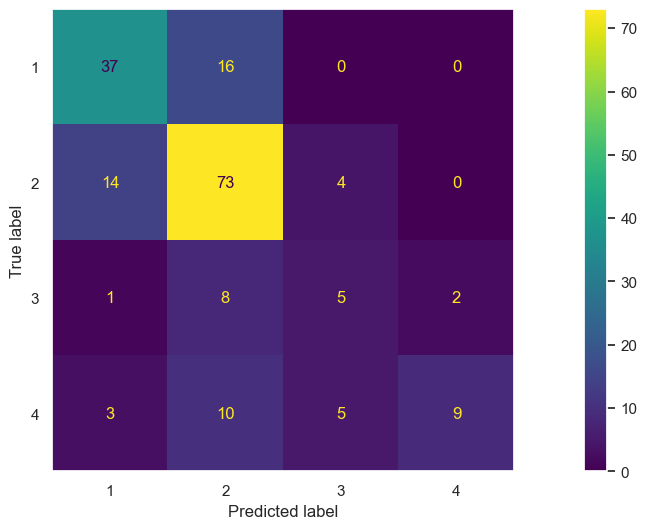

In [39]:
c_matrix = confusion_matrix(y_validation, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = c_matrix, display_labels=sorted(list(set(y_test))))
fig, ax = plt.subplots(figsize=(18, 6))
ax.grid(False)
cm_display.plot(ax=ax)
plt.show()

In [43]:
clf = CategoricalNB(min_categories=X.nunique())
cross_scores = cross_val_score(clf, X_train, y_train, cv=10)
print(cross_scores)
cross_scores.mean()

[0.60638298 0.46808511 0.6344086  0.5483871  0.53763441 0.51612903
 0.5483871  0.52688172 0.50537634 0.55913978]


0.5450812171127888

              precision    recall  f1-score   support

           1       0.61      0.75      0.67        53
           2       0.70      0.56      0.62        91
           3       0.20      0.25      0.22        16
           4       0.43      0.44      0.44        27

    accuracy                           0.57       187
   macro avg       0.48      0.50      0.49       187
weighted avg       0.59      0.57      0.58       187



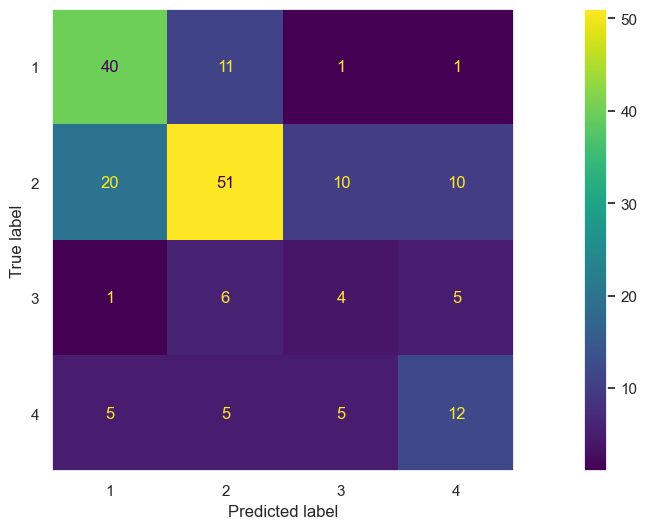

In [44]:
clf.fit(X_train_split, y_train_split)
y_pred = clf.predict(X_validation)
print(classification_report(y_validation, y_pred))
c_matrix = confusion_matrix(y_validation, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = c_matrix, display_labels=sorted(list(set(y_test))))
fig, ax = plt.subplots(figsize=(18, 6))
ax.grid(False)
cm_display.plot(ax=ax)
plt.show()

In [45]:
lda = LDA(store_covariance=True)
cross_scores = cross_val_score(lda, X_train, y_train, cv=10)
print(cross_scores)
cross_scores.mean()

[0.63829787 0.55319149 0.61290323 0.52688172 0.56989247 0.55913978
 0.50537634 0.58064516 0.60215054 0.61290323]


0.5761381834820407

In [46]:
lda.fit(X_train_split, y_train_split)
lda_pred = lda.predict(X_validation)
print(classification_report(y_validation, lda_pred))

              precision    recall  f1-score   support

           1       0.56      0.66      0.61        53
           2       0.68      0.55      0.61        91
           3       0.17      0.38      0.23        16
           4       0.73      0.41      0.52        27

    accuracy                           0.55       187
   macro avg       0.54      0.50      0.49       187
weighted avg       0.61      0.55      0.56       187



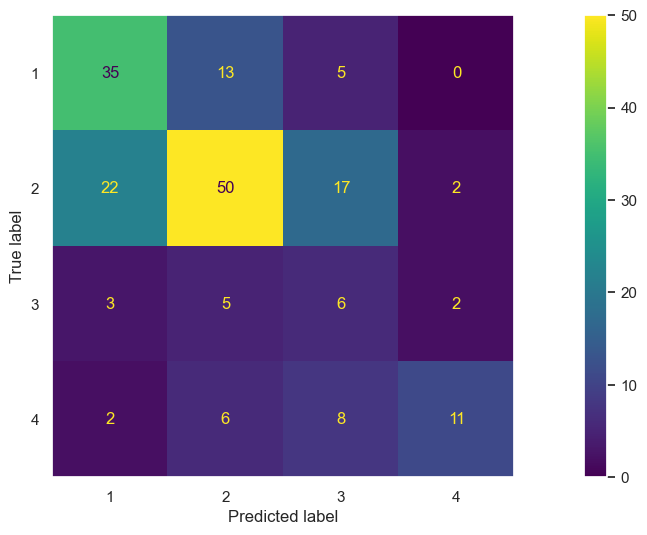

In [47]:
c_matrix = confusion_matrix(y_validation, lda_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = c_matrix, display_labels=sorted(list(set(y_test))))
fig, ax = plt.subplots(figsize=(18, 6))
ax.grid(False)
cm_display.plot(ax=ax)
plt.show()

In [59]:
rfc=RandomForestClassifier(random_state=0)

param_grid = { 
    'n_estimators': [300, 600, 800],
    'max_depth' : [10,12,14,16],
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [10, 12, 14, 16],
                         'n_estimators': [300, 600, 800]})

In [60]:
CV_rfc.best_params_

{'max_depth': 16, 'n_estimators': 800}

In [61]:
CV_rfc.best_score_

0.6737737910413432

In [62]:
rfc_pred = CV_rfc.best_estimator_.predict(X_test)
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

           1       0.72      0.60      0.65        57
           2       0.65      0.87      0.74       112
           3       0.42      0.16      0.23        32
           4       0.76      0.59      0.67        32

    accuracy                           0.67       233
   macro avg       0.64      0.55      0.57       233
weighted avg       0.65      0.67      0.64       233



Najlepszym klasyfikatorem został Random Forest Classifier